In [254]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchinfo import summary
import sys, os
import glob
import pickle
import matplotlib.pyplot as plt
import pathlib
import time
import skimage.transform as T

%matplotlib inline

In [255]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return {'data': dict[b'data'], 'labels': dict[b'labels']}

def combine_dicts(dicts: list)->dict:
    # keys: data, labels
    n = len(dicts)
    data, labels = dicts[0]['data'], dicts[0]['labels']
    for i in range(1,n):
        data = np.concatenate([data, dicts[i]['data']], axis=0)
        labels = labels + dicts[i]['labels']
    return {'data':data, 'labels':labels}

def array_to_rgb(arr: np.ndarray, augment=0)->np.ndarray:
    # take an 1x3072
    # reshape to rgb: 32, 32, 3
    rgb = np.reshape(arr, (32, 32, 3), order='F').astype(dtype=np.float32)
    rgb = rgb / 255.
    # rotate by 90 degrees
    rgb = np.rot90(rgb, k=1, axes=(1,0))
    rgb_data = [rgb]
    if augment:
        for i in range(2):
            for j in range(2):
                rgb_data.append(T.resize(rgb[16*i:(16*i)+16,16*j:(16*j)+16,:], (32,32)))
    return rgb_data

def show_image(arr: np.ndarray, augment=0)->None:
    rgb_imgs = array_to_rgb(arr,augment)
    num_imgs = len(rgb_imgs)
    print(rgb_imgs[0].shape)
    _, axs = plt.subplots(1,num_imgs, figsize=(2*num_imgs,2))
    if augment:
        axs = axs.flatten()
        for img, ax in zip(rgb_imgs, axs):
            ax.imshow(img)
    else:
        axs.imshow(rgb_imgs[0])
    plt.show()

def torch_from_numpy(arr: list)->torch.tensor:
    # convert to torch tensors
    #ndarrays = list(map(array_to_rgb, arr))
    tensors = [torch.from_numpy(item.copy()) for item in arr]
    return torch.einsum('nhwc->nchw', torch.stack(tensors, dim=0))

def make_dataset(d: dict, augment=0)->list:
    #data = list(map(array_to_rgb, d['data']))
    data = []
    for img in d['data']:
        data += array_to_rgb(img,augment)
    tensors = [torch.from_numpy(item.copy()) for item in data]
    tensors = torch.einsum('nhwc->nchw', torch.stack(tensors, dim=0))
    labels = d['labels']
    if augment:
        labels = []
        for label in d['labels']:
            labels += [label for i in range(5)]
    return list(zip(tensors, labels))

def print_model_summary(model):
    print(summary(model.conv, input_size=(3,32,32)))
    print(summary(model.dense, input_size=(1, 4*model.nf * 16)))

In [256]:
# conv layers of the network
class CNN(nn.Module):
    def __init__(self, channels, nf):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=nf, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=nf, out_channels=2*nf, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(in_channels=2*nf, out_channels=4*nf, kernel_size=3, stride=1, padding='same')
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)        
        self.bn_conv = nn.BatchNorm2d(nf)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn_conv(x)
        #x = self.dropout(x)
        x = self.maxpool(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        #x = self.bn_conv(x)
        #x = self.dropout(x)
        x = self.maxpool(x)
        x = F.relu(x)

        x = self.conv3(x)
        #x = self.bn_conv(x)
        #x = self.dropout(x)
        x = self.maxpool(x)
        x = F.relu(x)

        return x

# dense layers of the network
class FCNN(nn.Module):
    def __init__(self, nf):
        super(FCNN, self).__init__()
        # in: nfx4x4, flatten and feed to linear layer
        self.fc1 = nn.Linear(4*nf*4*4, 4*nf)
        self.bn_d1 = nn.BatchNorm1d(4*nf)
        self.fc2 = nn.Linear(4*nf, nf)
        self.bn_d2 = nn.BatchNorm1d(nf)        
        self.fc3 = nn.Linear(nf, 10)
        self.bn_d3 = nn.BatchNorm1d(10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_d1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.bn_d2(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.fc3(x)
        #x = self.bn_d3(x)
        return x

# combined model
class MODEL(nn.Module):
    def __init__(self, channels, nf):
        super(MODEL, self).__init__()
        self.conv = CNN(channels, nf)
        self.dense = FCNN(nf)
        self.nf = nf
        self.channels = channels
    
    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(1)
        x = self.dense(x)
        return x

In [257]:
# Conv block used in Resnet model
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same'),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

# Resnet9
class RESNET9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(RESNET9, self).__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        # classifier head
        self.fc = nn.Sequential(nn.MaxPool2d(kernel_size=4),
                                nn.Flatten(),
                                nn.Linear(512, num_classes))
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        return self.fc(x)

    def model_summary(self):
        return summary(self, input_size=(3,32,32))


In [258]:
# check if output shape as expected
test_model = RESNET9(3,10) #MODEL(3,10)
test_input = torch.randn(size=(64,3,32,32))
output = test_model(test_input)
output.shape
#print_model_summary(test_model)

torch.Size([64, 10])

In [259]:
def train_model(model, device, train_loader, loss_criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    total = 0
    total_acc = 0
    for batchidx, (data, target) in enumerate(train_loader):
        #print(f'batch id: {batchidx}')
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        predictions = output.argmax(dim=1, keepdim=True)
        #print(f'predictions: {predictions.shape}, target: {target.shape}')
        correct = predictions.eq(target.view_as(predictions)).sum().item()
        total_acc += (correct/len(data))
        total += len(data)
    avg_acc = total_acc/len(train_loader)
    avg_loss = train_loss/total
    print(f"Train epoch: {epoch} [{(batchidx+1) * len(data)}/{len(train_loader.dataset)}\
          ({(100. * batchidx/len(train_loader)):.0f}%)]\tLoss: {avg_loss:.6f}\tAcc: {100. * avg_acc:.6f}%")
    return 100. * avg_acc

def test_model(model, device, test_loader, loss_criterion):
    model.eval()
    test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criterion(output, target).item()
            predictions = output.argmax(dim=1, keepdim=True)
            #print(f'predictions: {predictions.shape}, target: {target.shape}')
            correct += predictions.eq(target.view_as(predictions)).sum().item()
            total += len(data)
    test_loss /= total
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({100. * correct/total:.0f}%)")
    return 100. * correct/total

In [260]:
data_dir = "../data/"
train_files = glob.glob(data_dir + '**/*_batch_*', recursive=True)
test_files = glob.glob(data_dir + '**/*test_batch*', recursive=True)
train_files = list(map(unpickle, train_files))
test_files = list(map(unpickle, test_files))
test = combine_dicts(test_files)
train = combine_dicts(train_files)
print(test['data'].shape)
print(train['data'].shape)

(10000, 3072)
(50000, 3072)


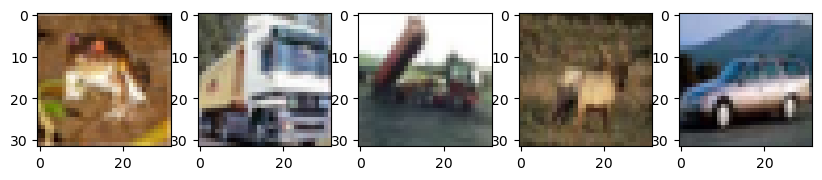

In [261]:
# plot sample images
sample_imgs = []
for img in train['data'][0:5]:
    sample_imgs += array_to_rgb(img)
#sample_imgs = list(map(array_to_rgb, train['data'][0:5]))
_, axs = plt.subplots(1,5, figsize=(10,2))
axs = axs.flatten()
for img, ax in zip(sample_imgs, axs):
    ax.imshow(img)
plt.show()

(32, 32, 3)


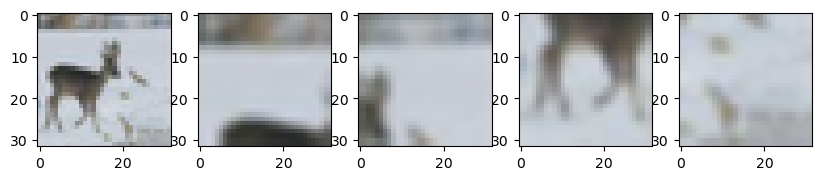

In [262]:
show_image(train['data'][20],augment=1)

In [263]:
trainset = make_dataset(train)
testset = make_dataset(test)
batch_size = 128
learning_rate = 0.2
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = RESNET9(3,10).to(device)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(testset, shuffle=False, batch_size=batch_size, drop_last=True)
print(f"test size: {len(testset)}")
print(f"train size: {len(trainset)}")
#print(model.model_summary())
#print_model_summary(model)

test size: 10000
train size: 50000


In [264]:
epochs = 10
train_acc = []
test_acc = []
for epoch in range(1,epochs+1):
    train_acc.append(train_model(model, device, train_loader, loss_criterion, optimizer, epoch))
    test_acc.append(test_model(model, device, test_loader, loss_criterion))

Train epoch: 1 [49920/50000          (100%)]	Loss: 0.008976	Acc: 60.220353%
Test set: Average loss: 0.0064, Accuracy: 7184/9984 (72%)
Train epoch: 2 [49920/50000          (100%)]	Loss: 0.004805	Acc: 78.515625%
Test set: Average loss: 0.0049, Accuracy: 7806/9984 (78%)
Train epoch: 3 [49920/50000          (100%)]	Loss: 0.003300	Acc: 85.494792%
Test set: Average loss: 0.0048, Accuracy: 7985/9984 (80%)
Train epoch: 4 [49920/50000          (100%)]	Loss: 0.002266	Acc: 90.062099%
Test set: Average loss: 0.0061, Accuracy: 7499/9984 (75%)
Train epoch: 5 [49920/50000          (100%)]	Loss: 0.001461	Acc: 93.673878%
Test set: Average loss: 0.0047, Accuracy: 8151/9984 (82%)
Train epoch: 6 [49920/50000          (100%)]	Loss: 0.000811	Acc: 96.790865%
Test set: Average loss: 0.0047, Accuracy: 8158/9984 (82%)
Train epoch: 7 [49920/50000          (100%)]	Loss: 0.000439	Acc: 98.461538%
Test set: Average loss: 0.0050, Accuracy: 8235/9984 (82%)
Train epoch: 8 [49920/50000          (100%)]	Loss: 0.000189	Ac

In [ ]:
pathlib.Path("saved_models").mkdir(exist_ok=True)
timestr = time.strftime("%Y%m%d-%H%M%S")
save_model_path = "saved_models/CIFAR10-"+timestr+".pth"
torch.save(model.state_dict(), save_model_path)